#### Objectives
1. How has pit stop duration changed over the years?
2. Relationship between pit stop duration and race circuit.
3. Relationship between pit stop count and race circuit.
4. What are the best pit stop windows in different circuits.

#### Setup

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

#### Reading data and EDA

In [88]:
pit_stops = pd.read_csv('datasets/cleaned/pit_stops.csv')
races = pd.read_csv('datasets/cleaned/races.csv')
circuits = pd.read_csv('datasets/original/circuits.csv')
results = pd.read_csv('datasets/cleaned/race_results.csv')

In [89]:
pit_stops.info()
pit_stops.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9299 entries, 0 to 9298
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   raceId        9299 non-null   int64 
 1   driverId      9299 non-null   int64 
 2   stop          9299 non-null   int64 
 3   lap           9299 non-null   int64 
 4   time          9299 non-null   object
 5   duration      9299 non-null   object
 6   milliseconds  9299 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 508.7+ KB


,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,0 days 17:05:23,0 days 00:00:26.898000,26898
1,841,30,1,1,0 days 17:05:52,0 days 00:00:25.021000,25021
2,841,17,1,11,0 days 17:20:48,0 days 00:00:23.426000,23426
3,841,4,1,12,0 days 17:22:34,0 days 00:00:23.251000,23251
4,841,13,1,13,0 days 17:24:10,0 days 00:00:23.842000,23842


In [90]:
# converting time and duration to timedelta and milliseconds to seconds
for col in ('time', 'duration'):
    pit_stops[col] = pd.to_timedelta(pit_stops[col])

pit_stops['seconds'] = pit_stops['milliseconds'].apply(lambda x : x/1000)
pit_stops.drop('milliseconds', axis = 1, inplace=True)

pit_stops.info()
pit_stops.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9299 entries, 0 to 9298
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype          
---  ------    --------------  -----          
 0   raceId    9299 non-null   int64          
 1   driverId  9299 non-null   int64          
 2   stop      9299 non-null   int64          
 3   lap       9299 non-null   int64          
 4   time      9299 non-null   timedelta64[ns]
 5   duration  9299 non-null   timedelta64[ns]
 6   seconds   9299 non-null   float64        
dtypes: float64(1), int64(4), timedelta64[ns](2)
memory usage: 508.7 KB


,raceId,driverId,stop,lap,time,duration,seconds
0,841,153,1,1,0 days 17:05:23,0 days 00:00:26.898000,26.898
1,841,30,1,1,0 days 17:05:52,0 days 00:00:25.021000,25.021
2,841,17,1,11,0 days 17:20:48,0 days 00:00:23.426000,23.426
3,841,4,1,12,0 days 17:22:34,0 days 00:00:23.251000,23.251
4,841,13,1,13,0 days 17:24:10,0 days 00:00:23.842000,23.842


In [91]:
pit_stops.describe().T

,count,mean,std,min,25%,50%,75%,max
raceId,9299.0,951.234004,73.745962,841.0,884.0,949.0,1016.0,1086.0
driverId,9299.0,505.108506,392.872898,1.0,18.0,815.0,830.0,855.0
stop,9299.0,1.762448,0.916863,1.0,1.0,2.0,2.0,6.0
lap,9299.0,25.160662,14.507436,1.0,13.0,25.0,36.0,78.0
time,9299,0 days 15:54:19.630497903,0 days 01:47:40.013505490,0 days 13:04:31,0 days 14:40:31,0 days 15:23:30,0 days 16:26:23,0 days 22:32:14
duration,9299,0 days 00:01:13.422619636,0 days 00:04:38.200465324,0 days 00:00:12.897000,0 days 00:00:21.906000,0 days 00:00:23.546000,0 days 00:00:26.237000,0 days 00:51:09.017000
seconds,9299.0,73.42262,278.200465,12.897,21.906,23.546,26.237,3069.017


Observations:
We know that the ideal pit stop duration on any circuit today is between 20 and 30s and the median gives the same picture. However, since we see such a high difference between the mean and the median, we can conclude that this is caused by outliers highlighted by the max value which is 3069s (which is 51min!)

#### Joining the DataFrames

In [92]:
merged_df1 = pd.merge(pit_stops, races, on='raceId', how='left')
merged_df2 = pd.merge(merged_df1, results, on=['raceId', 'driverId'], how='left')
df = pd.merge(merged_df2, circuits, on='circuitId', how='left')
df.head()

,raceId,driverId,stop,lap,time_x,duration,seconds,year,round,circuitId,...,fastestLapSpeed,statusId,circuitRef,name_y,location,country,lat,lng,alt,url
0,841,153,1,1,0 days 17:05:23,0 days 00:00:26.898000,26.898,2011,1,1,...,211.025,11,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,841,30,1,1,0 days 17:05:52,0 days 00:00:25.021000,25.021,2011,1,1,...,200.283,4,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
2,841,17,1,11,0 days 17:20:48,0 days 00:00:23.426000,23.426,2011,1,1,...,213.066,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
3,841,4,1,12,0 days 17:22:34,0 days 00:00:23.251000,23.251,2011,1,1,...,213.336,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
4,841,13,1,13,0 days 17:24:10,0 days 00:00:23.842000,23.842,2011,1,1,...,214.631,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...


In [93]:
df.columns

Index(['raceId', 'driverId', 'stop', 'lap', 'time_x', 'duration', 'seconds',
       'year', 'round', 'circuitId', 'name_x', 'date', 'constructorId', 'grid',
       'positionOrder', 'points', 'laps', 'time_y', 'milliseconds',
       'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId',
       'circuitRef', 'name_y', 'location', 'country', 'lat', 'lng', 'alt',
       'url'],
      dtype='object')

In [94]:
df.drop(columns={'time_x','round','date','constructorId','points','time_y','milliseconds','fastestLap','rank','fastestLapTime',
                'fastestLapSpeed','country','lat','lng','alt','url'}, inplace=True)
df.head()

,raceId,driverId,stop,lap,duration,seconds,year,circuitId,name_x,grid,positionOrder,laps,statusId,circuitRef,name_y,location
0,841,153,1,1,0 days 00:00:26.898000,26.898,2011,1,Australian Grand Prix,12,11,57,11,albert_park,Albert Park Grand Prix Circuit,Melbourne
1,841,30,1,1,0 days 00:00:25.021000,25.021,2011,1,Australian Grand Prix,11,19,19,4,albert_park,Albert Park Grand Prix Circuit,Melbourne
2,841,17,1,11,0 days 00:00:23.426000,23.426,2011,1,Australian Grand Prix,3,5,58,1,albert_park,Albert Park Grand Prix Circuit,Melbourne
3,841,4,1,12,0 days 00:00:23.251000,23.251,2011,1,Australian Grand Prix,5,4,58,1,albert_park,Albert Park Grand Prix Circuit,Melbourne
4,841,13,1,13,0 days 00:00:23.842000,23.842,2011,1,Australian Grand Prix,8,7,58,1,albert_park,Albert Park Grand Prix Circuit,Melbourne


In [95]:
df = df.rename(columns={'name_x': 'raceName','name_y': 'circuitName'})

### Objective 1
#### How pit stop durations have varied over time?
1. Pit stop durations saw a significant increase from 2012 to 2014, more specifically from 2013 to 2014 with the beginning of the Turbo-Hybrid era.
2. Pit stop durations have remainded fairly stable from 2014 onwards.
3. Majority of the durations are centered around 20-30s.
4. Variance drastically increases from 2019.

In [96]:
fig = px.line(df.groupby(by = 'year').median().reset_index(), 
                x='year', 
                y='seconds',
                title='Median Pit Stop Durations')
fig.show()

In [97]:
fig = px.box(df, x='year', y='seconds', title='Pit Stop Durations')
fig.show()

In [98]:
fig = px.box(df[df['seconds'] < 50], x='year', y='seconds', title='Pit Stop Durations')
fig.show()


In [99]:
fig = px.line(df.groupby(by='year').var().reset_index(),
              x='year',
              y='seconds',
              title='Variance in Pit Stop Durations')
fig.show()

### Objective 2
#### Relationship between Pit Stop duration and race circuit.
1. Race circuits do have an impact on pit stop durations.
2. Number of laps (and hence length of the circuit) doesn't seem to have any correlation with pit stop durations.
3. Some circuits have larger variances then others, but overall the variances appear to be fairly consistent.

In [100]:
fig = px.box(df[df['seconds'] < 50].groupby(by=['raceId', 'raceName', 'circuitName']).mean().reset_index().sort_values(
        by='seconds', ascending=True),
             x='circuitName',
             y='seconds',
            title='Pit Stop Durations by Race Circuit'
            )
fig.show()


In [101]:
# Top 10 circuits with highest average pit stop duration
mean_pit_stop = df[df['seconds'] < 50].groupby(by=['circuitName']).mean().sort_values(
    by='seconds', ascending=False).reset_index()[['circuitId', 'circuitName', 'seconds']]
mean_pit_stop[:10]

,circuitId,circuitName,seconds
0,21.0,Autodromo Enzo e Dino Ferrari,31.792301
1,34.0,Circuit Paul Ricard,31.715573
2,71.0,Sochi Autodrom,31.045954
3,15.0,Marina Bay Street Circuit,30.256828
4,9.0,Silverstone Circuit,28.694033
5,6.0,Circuit de Monaco,26.569842
6,78.0,Losail International Circuit,26.418167
7,2.0,Sepang International Circuit,25.389954
8,69.0,Circuit of the Americas,25.211767
9,3.0,Bahrain International Circuit,25.197705


Note: The order in the box plot and list may be different because we are grouping by different column sets but the general trend remains the same

In [102]:
# Number of laps in a race is inversely proportional to the length of the circuit
# We attempt to find a correlation between number of laps and pit stop duration
fig = px.scatter(df[df['seconds'] < 50].groupby(by=['circuitName']).agg({'seconds': 'mean', 'laps': 'max'})[['seconds', 'laps']].reset_index().sort_values(
    by='seconds', ascending=True),
    x='laps',
    y='seconds',
    title='Number of Laps vs Pit Stop Duration'
)
fig.show()

In [103]:
fig = px.box(df[df['seconds'] < 50].groupby(by=['raceId', 'raceName', 'circuitName']).var().reset_index().sort_values(
    by='seconds', ascending=True),
    x='circuitName',
    y='seconds',
    title='Variance in Pit Stop Durations by Race Circuit'
)
fig.show()


### Objective 3
#### Relationship between Pit Stop count and race circuit.
1. Race circuits have a significant impact on pit stop count. We see that Mugello has seen by far the highest number of pit stops on average.
2. Number of laps (and hence, length of circuit) do not seem to have any correlation with pit stop count.
3. Variance also looks to be dependent on race circuit. This means that circuits with higher variance do not have a definite pit stop strategy that every team counts on.

In [104]:
stops_df = df[df['seconds'] < 50].groupby(by=['raceId', 'driverId', 'circuitName']).agg({'stop': 'max', 'laps': 'max'})
fig = px.line(stops_df.groupby(by='circuitName').mean().reset_index().sort_values(
    by='stop', ascending=True),
    x='circuitName',
    y='stop',
    title='Average Pit Stop count by Race Circuit'
)
fig.show()

In [105]:
# Top 10 circuits with highest average pit stop count
stops_df.groupby(by='circuitName').mean().sort_values(by='stop', ascending=False)['stop'][:10]

circuitName
Autodromo Internazionale del Mugello    3.857143
Autódromo José Carlos Pace              2.791667
Hockenheimring                          2.790476
Sepang International Circuit            2.645390
Marina Bay Street Circuit               2.572973
Shanghai International Circuit          2.489362
Bahrain International Circuit           2.478992
Valencia Street Circuit                 2.425532
Hungaroring                             2.404082
Circuit de Barcelona-Catalunya          2.403292
Name: stop, dtype: float64

In [106]:
fig = px.scatter(stops_df.groupby('circuitName').agg({'stop': 'mean', 'laps': 'max'}).reset_index().sort_values(
    by='stop', ascending=True),
    x='laps',
    y='stop',
    title='Average Number of Laps vs Pit Stop count'
)
fig.show()

In [107]:
fig = px.line(stops_df.groupby(by='circuitName').var().reset_index().sort_values(
    by='stop', ascending=True),
    x='circuitName',
    y='stop',
    title='Variance in Pit Stop count by Race Circuit'
)
fig.show()

### Objective 4
#### What are the best pit stop windows at different circuits?
For the sake of relevance, we'll only consider the circuits where races are currently held and we'll only consider pit stop data pertaining to the turbo hybrid era of F1, i.e, 2014 onwards.

In [108]:
# Circuit IDs of all the circuits that were part of the 2021 and 2022 calendars
circuit_ids = set(races[races['year'] == 2021]['circuitId']) | set(races[races['year'] == 2022]['circuitId'])

In [109]:
# Picking only those rows with circuitId in the set circuit_ids
filtered_df = df[(df['circuitId'].isin(circuit_ids)) & (df['statusId'].isin([1,11,12,13]))]
filtered_df.head()

,raceId,driverId,stop,lap,duration,seconds,year,circuitId,raceName,grid,positionOrder,laps,statusId,circuitRef,circuitName,location
0,841,153,1,1,0 days 00:00:26.898000,26.898,2011,1,Australian Grand Prix,12,11,57,11,albert_park,Albert Park Grand Prix Circuit,Melbourne
2,841,17,1,11,0 days 00:00:23.426000,23.426,2011,1,Australian Grand Prix,3,5,58,1,albert_park,Albert Park Grand Prix Circuit,Melbourne
3,841,4,1,12,0 days 00:00:23.251000,23.251,2011,1,Australian Grand Prix,5,4,58,1,albert_park,Albert Park Grand Prix Circuit,Melbourne
4,841,13,1,13,0 days 00:00:23.842000,23.842,2011,1,Australian Grand Prix,8,7,58,1,albert_park,Albert Park Grand Prix Circuit,Melbourne
6,841,20,1,14,0 days 00:00:22.603000,22.603,2011,1,Australian Grand Prix,1,1,58,1,albert_park,Albert Park Grand Prix Circuit,Melbourne


In [110]:
# Selecting columns with year>=2014
filtered_df = filtered_df[filtered_df['year'] >= 2014]
filtered_df.head()

,raceId,driverId,stop,lap,duration,seconds,year,circuitId,raceName,grid,positionOrder,laps,statusId,circuitRef,circuitName,location
3012,900,821,1,1,0 days 00:00:32.657000,32.657,2014,1,Australian Grand Prix,20,12,56,11,albert_park,Albert Park Grand Prix Circuit,Melbourne
3013,900,815,1,1,0 days 00:00:25.541000,25.541,2014,1,Australian Grand Prix,16,10,57,1,albert_park,Albert Park Grand Prix Circuit,Melbourne
3014,900,18,1,11,0 days 00:00:22.411000,22.411,2014,1,Australian Grand Prix,10,3,57,1,albert_park,Albert Park Grand Prix Circuit,Melbourne
3015,900,815,2,11,0 days 00:00:22.497000,22.497,2014,1,Australian Grand Prix,16,10,57,1,albert_park,Albert Park Grand Prix Circuit,Melbourne
3016,900,3,1,12,0 days 00:00:24.331000,24.331,2014,1,Australian Grand Prix,3,1,57,1,albert_park,Albert Park Grand Prix Circuit,Melbourne


In [111]:
# Splitting dataset into those who ended up gaining positions at the end of the race and those who didn't
gained_df = filtered_df[filtered_df['positionOrder'] < filtered_df['grid']]
lost_df = filtered_df[filtered_df['positionOrder'] >= filtered_df['grid']]

In [112]:
gained_stops_df = gained_df.groupby(by=['circuitName', 'stop', 'driverId']).agg(stopLap=('lap','mean'), raceLaps=('laps', 'max')).reset_index()
gained_stops_df

,circuitName,stop,driverId,stopLap,raceLaps
0,Albert Park Grand Prix Circuit,1,1,22.0,58
1,Albert Park Grand Prix Circuit,1,3,12.0,57
2,Albert Park Grand Prix Circuit,1,4,19.0,58
3,Albert Park Grand Prix Circuit,1,8,12.0,57
4,Albert Park Grand Prix Circuit,1,9,1.0,55
...,...,...,...,...,...
1553,Yas Marina Circuit,2,842,54.0,58
1554,Yas Marina Circuit,2,849,35.0,54
1555,Yas Marina Circuit,2,852,53.0,58
1556,Yas Marina Circuit,2,854,52.0,57


<AxesSubplot:xlabel='circuitName', ylabel='stopLap'>

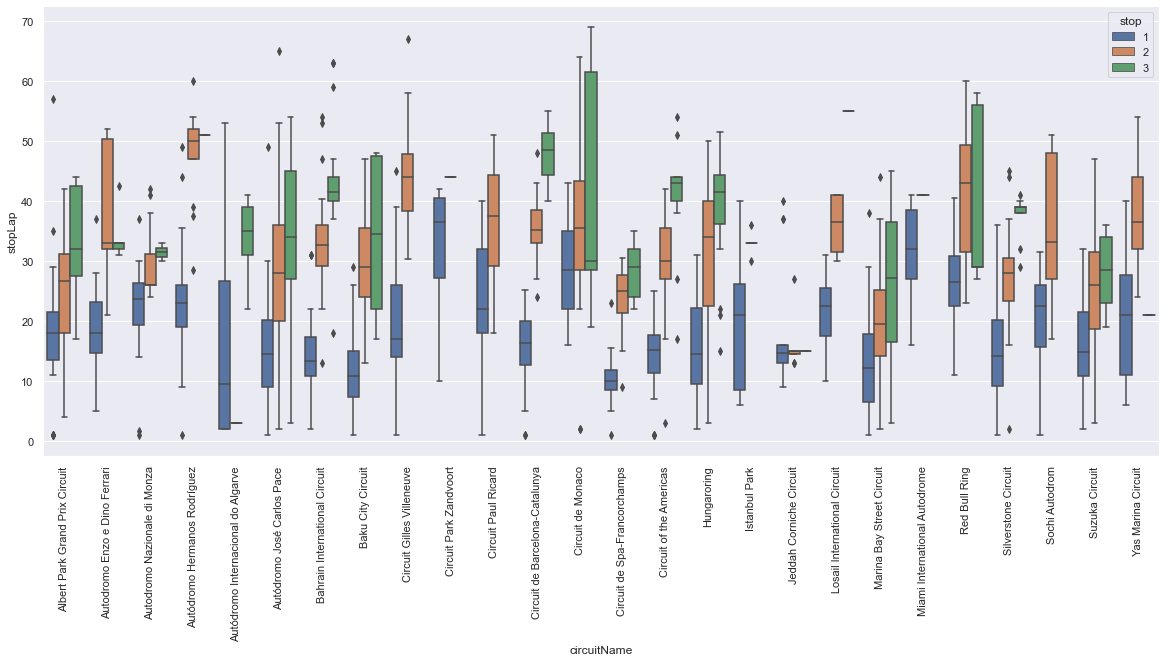

In [113]:
plt.xticks(rotation=90)
gained_stops_df = gained_stops_df[gained_stops_df['stop'].isin([1, 2, 3])]
sns.boxplot(x=gained_stops_df['circuitName'],
            y=gained_stops_df['stopLap'], hue=gained_stops_df['stop'])


In [114]:
lost_stops_df = lost_df.groupby(by=['circuitName', 'stop', 'driverId']).agg(
    stopLap=('lap', 'mean'), raceLaps=('laps', 'max')).reset_index()
lost_stops_df

,circuitName,stop,driverId,stopLap,raceLaps
0,Albert Park Grand Prix Circuit,1,1,18.4,58
1,Albert Park Grand Prix Circuit,1,3,26.0,58
2,Albert Park Grand Prix Circuit,1,4,39.0,57
3,Albert Park Grand Prix Circuit,1,8,22.0,58
4,Albert Park Grand Prix Circuit,1,13,21.0,58
...,...,...,...,...,...
1308,Yas Marina Circuit,3,831,44.0,54
1309,Yas Marina Circuit,3,835,41.0,54
1310,Yas Marina Circuit,3,840,35.0,54
1311,Yas Marina Circuit,3,850,48.0,53


<AxesSubplot:xlabel='circuitName', ylabel='stopLap'>

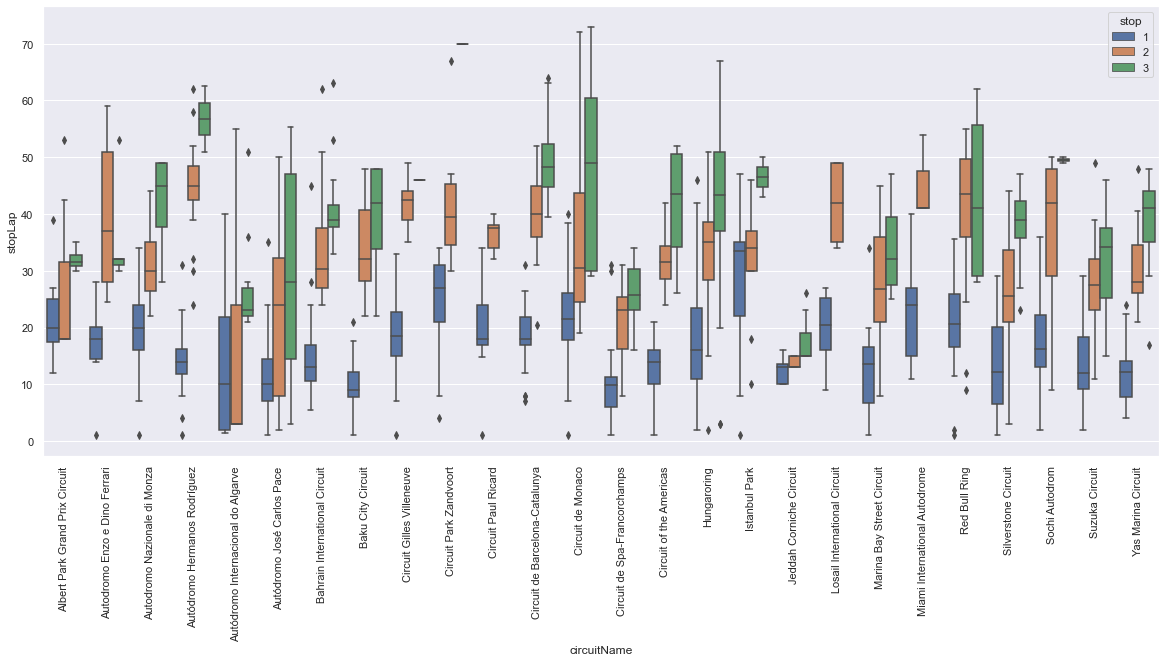

In [115]:
plt.xticks(rotation=90)
lost_stops_df = lost_stops_df[lost_stops_df['stop'].isin([1, 2, 3])]
sns.boxplot(x=lost_stops_df['circuitName'],
            y=lost_stops_df['stopLap'], hue=lost_stops_df['stop'])
